In [0]:
#Based on https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb

In [28]:
import tensorflow as tf
import tensorflow.keras
tf.keras.__version__

'2.1.6-tf'

In [0]:
from tensorflow.keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

In [0]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [31]:
x_train[0]

array([  65,   16,   38, 1334,   88,   12,   16,  283,    5,   16, 4472,
        113,  103,   32,   15,   16, 5345,   19,  178,   32], dtype=int32)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 71us/step - loss: 0.6598 - acc: 0.6411 - val_loss: 0.5997 - val_acc: 0.7092
Epoch 2/10
20000/20000 [==============================] - 1s 57us/step - loss: 0.5276 - acc: 0.7581 - val_loss: 0.5178 - val_acc: 0.7360
Epoch 3/10
20000/20000 [==============================] - 1s 55us/step - loss: 0.4569 - acc: 0.7900 - val_loss: 0.4970 - val_acc: 0.7502
Epoch 4/10
20000/20000 [==============================] - 1s 56us/step - loss: 0.4215 - acc: 0.8092 - val_loss: 0.4927 - val_acc: 0.7538
Epoch 5/10
20000/20000 [==============================] - 1s 56us/step - loss: 0.3968 - acc: 0.8219 - val_loss: 0.4928 - val_acc: 0.7572
Epoch 6/10
20000/20000 [==============================] - 1s 56us/step - loss: 0.3763 - acc: 0.8326 - val_loss: 0.4963 - val_acc: 0.7598
Epoch 7/10
20000/20000 [==============================] - 1s 56us/step - loss: 0.3582 - acc: 0.8439 - val_loss: 0.5033 - val_acc:

In [33]:
!rm -rf aclImdb_v1.tar.gz*
!curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  13.3M      0  0:00:05  0:00:05 --:--:-- 17.7M


In [0]:
!tar -zxf aclImdb_v1.tar.gz 

In [0]:
import os

imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenize the data


Let's vectorize the texts we collected, and prepare a training and validation split.
We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, 
task-specific embeddings are likely to outperform them), we will add the following twist: we restrict the training data to its first 200 
samples. So we will be learning to classify movie reviews after looking at just 200 examples...


In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 20000  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [37]:
x_train[0]

array([  10,   13, 2231,   58, 1748,    6,    8,   46, 3832,   26,   13,
          8,    3, 2549, 4102, 1694,  294, 1712, 2149,   91,  324,  316,
         87,   20,  245,   26,   13,   79,   20, 1459, 4140, 1374,  546,
         26,  207,   76,    1,  389,  170, 1078, 1078,  135,   78,   72,
         25,    5,  205,  155,  408, 1581,   35,  376,   10,  101,  143,
        221,  112,  327,  143,  128,   21,  221,   48,    6,   11,    3,
        973,  135,   78,   72,   25,    5,  137,   29,    1,   93,    5,
        344,  744,   63,  802,    1,  210,    4,    9,   10,   77,   40,
        205, 1522,  712,   15,  147,   62,    6,  250,   10,  116,   58,
        365], dtype=int32)

### Download the GloVe word embeddings


Head to `https://nlp.stanford.edu/projects/glove/` (where you can learn more about the GloVe algorithm), and download the pre-computed 
embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

### Pre-process the embeddings


Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number 
vectors).

In [38]:
!rm -rf glove.6B.zip*
!curl -O https://nlp.stanford.edu/data/glove.6B.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  822M  100  822M    0     0  2339k      0  0:05:59  0:05:59 --:--:-- 4849k


In [39]:
!ls -lah

total 3.0G
drwxr-xr-x 1 root root 4.0K Oct 24 15:36 .
drwxr-xr-x 1 root root 4.0K Oct 24 11:44 ..
drwxr-xr-x 4 7297 1000 4.0K Jun 26  2011 aclImdb
-rw-r--r-- 1 root root  81M Oct 24 15:35 aclImdb_v1.tar.gz
drwxr-xr-x 4 root root 4.0K Oct 22 18:12 .config
drwxr-xr-x 2 root root 4.0K Oct 24 12:00 gdline_frames
-rw-r--r-- 1 root root 6.3K Oct 24 12:00 gdline.htm
-rw-rw-r-- 1 root root 332M Aug  4  2014 glove.6B.100d.txt
-rw-rw-r-- 1 root root 662M Aug  4  2014 glove.6B.200d.txt
-rw-rw-r-- 1 root root 990M Aug 27  2014 glove.6B.300d.txt
-rw-rw-r-- 1 root root 164M Aug  4  2014 glove.6B.50d.txt
-rw-r--r-- 1 root root 823M Oct 24 15:42 glove.6B.zip
-rw-r--r-- 1 root root    0 Oct 24 12:00 None0000000.png
-rw-r--r-- 1 root root 6.3M Oct 24 15:16 pre_trained_glove_model.h5
drwxr-xr-x 2 root root 4.0K Oct 22 18:24 sample_data


In [0]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [20]:
glove_dir = './'


embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [22]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

Using TensorFlow backend.


In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [24]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 9s 456us/step - loss: 0.7172 - acc: 0.4998 - val_loss: 0.6931 - val_acc: 0.5028
Epoch 2/10
20000/20000 [==============================] - 9s 435us/step - loss: 0.6964 - acc: 0.5037 - val_loss: 0.6917 - val_acc: 0.5230
Epoch 3/10
20000/20000 [==============================] - 9s 432us/step - loss: 0.6900 - acc: 0.5422 - val_loss: 0.6525 - val_acc: 0.6472
Epoch 4/10
20000/20000 [==============================] - 9s 434us/step - loss: 0.6714 - acc: 0.5797 - val_loss: 0.6525 - val_acc: 0.6306
Epoch 5/10
20000/20000 [==============================] - 9s 442us/step - loss: 0.6503 - acc: 0.6155 - val_loss: 0.6398 - val_acc: 0.6304
Epoch 6/10
20000/20000 [==============================] - 9s 440us/step - loss: 0.6278 - acc: 0.6434 - val_loss: 0.5952 - val_acc: 0.7154
Epoch 7/10
20000/20000 [==============================] - 9s 440us/step - loss: 0.6039 - acc: 0.6777 - val_loss: 0.5765 - v

Let's plot its performance over time:

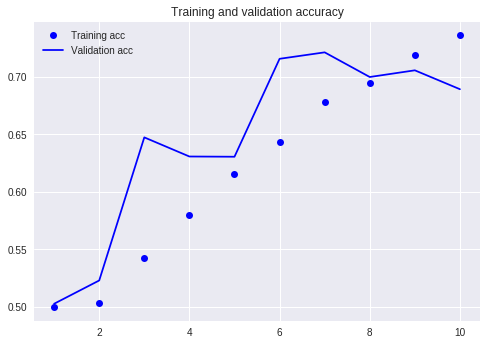

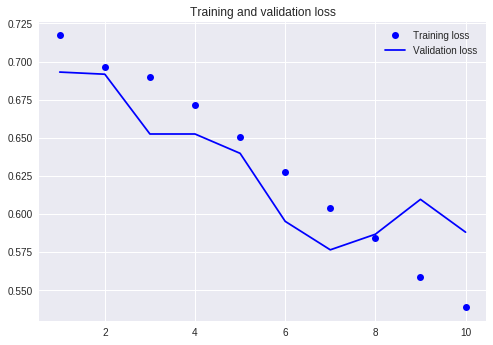

In [25]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for 
the same reason, but seems to reach high 50s.

Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we 
picked, and we picked them at random. If it worked really poorly for you, try picking a different random set of 200 samples, just for the 
sake of the exercise (in real life you don't get to pick your training data).

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that 
case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings 
when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

In [26]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 13s 632us/step - loss: 0.4307 - acc: 0.7904 - val_loss: 0.3535 - val_acc: 0.8486
Epoch 2/10
20000/20000 [==============================] - 12s 618us/step - l

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Validation accuracy stalls in the low 50s. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If you 
increase the number of training samples, this will quickly stop being the case -- try it as an exercise.

Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data:

In [0]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)